### import the dependencies

In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

from torchdiffeq import odeint

from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

DATA_PATH = os.path.join("..", "Dataset", "raw_RRI_segments.csv")
OUT_MODEL = os.path.join("..", "Two_Class_Models", "saved_models", "raw_hybrid_two_class_best.pth")

### Load Raw dataset and preprocess

In [2]:
df = pd.read_csv(DATA_PATH)

# Merge SR (0) + Pre-AF (1) → 0 (non-AF), keep AF (2) → 1 (AF)
mask_binary = df["label"].isin([0, 1, 2])
df = df[mask_binary].copy()

# Remap labels
df["label"] = df["label"].map({
    0: 0,  # SR → non-AF
    1: 0,  # Pre-AF → non-AF
    2: 1   # AF → AF
})

# Pick raw RRI columns (prefix 'r_')
feature_cols = [c for c in df.columns if c.startswith("r_")]
meta_cols = ["patient_id", "record_id", "label", "label_str", "orig_len"]

assert len(feature_cols) > 0, "No r_ columns found in CSV"

# Extract feature matrix and labels
X = df[feature_cols].values.astype(np.float32)
y = df["label"].values.astype(int)

# Drop rows with NaN or Inf
mask_good = np.isfinite(X).all(axis=1)
X = X[mask_good]
y = y[mask_good]

print("Loaded raw samples:", X.shape)
print("Class counts:", np.bincount(y))
print("Unique labels:", np.unique(y))


Loaded raw samples: (14357, 50)
Class counts: [9557 4800]
Unique labels: [0 1]


### Train / val / test split, scaling and SMOTE (apply SMOTE only to training set)

In [3]:
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_SEED
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.2, stratify=y_temp, random_state=RANDOM_SEED
)

print("Splits -> train:", X_train.shape, "val:", X_val.shape, "test:", X_test.shape)

# Standardize using training stats
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

X_train_res, y_train_res = X_train, y_train


Splits -> train: (9188, 50) val: (2297, 50) test: (2872, 50)


### Compute class weights

In [4]:
# compute class weights from resampled training set (used as alpha for focal loss)
cw = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_res), y=y_train_res)
class_weights_tensor = torch.tensor(cw, dtype=torch.float32)
print("Class weights:", cw)

Class weights: [0.75114454 1.49544271]


### Define model class

In [5]:
# --- Model definitions (Hybrid NODE + Attention) ---
class ODEFunc(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, 64),
            nn.Tanh(),
            nn.Linear(64, dim)
        )
    def forward(self, t, x):
        return self.net(x)

class SelfAttention(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.query = nn.Linear(dim, dim)
        self.key = nn.Linear(dim, dim)
        self.value = nn.Linear(dim, dim)
        self.scale = dim ** 0.5
    def forward(self, x):
        # x: [batch, dim] -> [batch, 1, dim]
        x1 = x.unsqueeze(1)
        Q = self.query(x1)
        K = self.key(x1)
        V = self.value(x1)
        scores = torch.softmax(torch.bmm(Q, K.transpose(1,2)) / self.scale, dim=-1)
        out = torch.bmm(scores, V)  # [batch,1,dim]
        return out.squeeze(1)

class HybridNODEAttentionModel(nn.Module):
    def __init__(self, dim, num_classes):
        super().__init__()
        self.odefunc = ODEFunc(dim)
        self.attn = SelfAttention(dim)
        self.classifier = nn.Sequential(
            nn.Linear(dim, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )
    def forward(self, x):
        # x: [batch, dim]
        t = torch.tensor([0.0, 1.0], dtype=x.dtype, device=x.device)
        ode_out = odeint(self.odefunc, x, t)[-1]
        attn_out = self.attn(ode_out)
        return self.classifier(attn_out)


### Prepare DataLoaders

In [6]:
BATCH_SIZE = 32
train_ds = TensorDataset(torch.from_numpy(X_train_res.astype(np.float32)), torch.from_numpy(y_train_res.astype(np.int64)))
val_ds = TensorDataset(torch.from_numpy(X_val.astype(np.float32)), torch.from_numpy(y_val.astype(np.int64)))
test_ds = TensorDataset(torch.from_numpy(X_test.astype(np.float32)), torch.from_numpy(y_test.astype(np.int64)))

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_dim = X_train_res.shape[1]
num_classes = int(np.unique(y).size)

### Train model (hyperparameter tuning)

In [7]:
from sklearn.model_selection import KFold
from torch.utils.data import Subset
import torch.nn.functional as F
from sklearn.metrics import f1_score
import itertools
import numpy as np
import torch

def train_with_kfold_tuning(model_class, input_dim, num_classes,
                            full_dataset, class_weights_tensor,
                            param_grid,
                            save_path,
                            epochs=8, patience=2,
                            k_folds=5, device='cuda'):
    class_weights_tensor = class_weights_tensor.to(device)
    best_global_f1 = 0.0
    best_params = None
    best_state = None

    kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)
    combos = list(itertools.product(*param_grid.values()))
    print(f"Total combinations: {len(combos)}  |  Using {k_folds}-fold cross-validation")

    for combo in combos:
        params = dict(zip(param_grid.keys(), combo))
        print(f"\nTesting hyperparameters: {params}")
        fold_f1s = []

        for fold, (train_idx, val_idx) in enumerate(kfold.split(np.arange(len(full_dataset)))):
            train_subset = Subset(full_dataset, train_idx)
            val_subset = Subset(full_dataset, val_idx)

            train_loader = DataLoader(train_subset, batch_size=params["batch_size"], shuffle=True)
            val_loader = DataLoader(val_subset, batch_size=params["batch_size"], shuffle=False)

            model = model_class(dim=input_dim, num_classes=num_classes).to(device)
            optimizer = (
                torch.optim.Adam(model.parameters(), lr=params["lr"])
                if params["optimizer"] == "adam"
                else torch.optim.SGD(model.parameters(), lr=params["lr"], momentum=0.9)
            )
            criterion = nn.CrossEntropyLoss()

            local_best = 0.0
            no_improve = 0

            for epoch in range(epochs):
                model.train()
                total_loss = 0
                for xb, yb in train_loader:
                    xb, yb = xb.to(device), yb.to(device)
                    optimizer.zero_grad()
                    out = model(xb)
                    loss = criterion(out, yb)
                    loss.backward()
                    optimizer.step()
                    total_loss += loss.item() * xb.size(0)

                # Validation
                model.eval()
                preds, trues = [], []
                with torch.no_grad():
                    for xb, yb in val_loader:
                        xb, yb = xb.to(device), yb.to(device)
                        out = model(xb)
                        preds.extend(torch.argmax(out, dim=1).cpu().numpy())
                        trues.extend(yb.cpu().numpy())

                val_f1 = f1_score(trues, preds, average="weighted")
                if val_f1 > local_best:
                    local_best = val_f1
                    no_improve = 0
                else:
                    no_improve += 1
                    if no_improve >= patience:
                        break

            fold_f1s.append(local_best)
            print(f"  Fold {fold+1}/{k_folds} F1: {local_best:.4f}")

        mean_f1 = np.mean(fold_f1s)
        print(f"Mean F1 for params {params}: {mean_f1:.4f}")

        if mean_f1 > best_global_f1:
            best_global_f1 = mean_f1
            best_params = params
            best_state = model.state_dict().copy()
            torch.save(best_state, save_path)
            print("  ✅ New best model saved.")

    print(f"\nBest overall F1: {best_global_f1:.4f} with params {best_params}")
    return best_params, best_global_f1, best_state



In [8]:
train_dataset = TensorDataset(torch.from_numpy(X_train_res.astype(np.float32)), torch.from_numpy(y_train_res.astype(np.int64)))
val_dataset = TensorDataset(torch.from_numpy(X_val.astype(np.float32)), torch.from_numpy(y_val.astype(np.int64)))
test_dataset = TensorDataset(torch.from_numpy(X_test.astype(np.float32)), torch.from_numpy(y_test.astype(np.int64)))

input_dim = X_train_res.shape[1]
num_classes = int(np.unique(y).size)

In [9]:
full_dataset = TensorDataset(
    torch.from_numpy(X_train_res.astype(np.float32)),
    torch.from_numpy(y_train_res.astype(np.int64))
)

param_grid = {
    "lr": [1e-3, 5e-4],
    "batch_size": [16, 32],
    "optimizer": ["adam", "sgd"]
}

best_params, best_f1, best_state = train_with_kfold_tuning(
    HybridNODEAttentionModel, input_dim, num_classes,
    full_dataset, class_weights_tensor,
    param_grid, save_path=OUT_MODEL,
    epochs=8, patience=2, k_folds=5, device=device
)


Total combinations: 8  |  Using 5-fold cross-validation

Testing hyperparameters: {'lr': 0.001, 'batch_size': 16, 'optimizer': 'adam'}
  Fold 1/5 F1: 0.8829
  Fold 2/5 F1: 0.8685
  Fold 3/5 F1: 0.8779
  Fold 4/5 F1: 0.8767
  Fold 5/5 F1: 0.8750
Mean F1 for params {'lr': 0.001, 'batch_size': 16, 'optimizer': 'adam'}: 0.8762
  ✅ New best model saved.

Testing hyperparameters: {'lr': 0.001, 'batch_size': 16, 'optimizer': 'sgd'}
  Fold 1/5 F1: 0.8628
  Fold 2/5 F1: 0.8440
  Fold 3/5 F1: 0.8613
  Fold 4/5 F1: 0.8557
  Fold 5/5 F1: 0.8585
Mean F1 for params {'lr': 0.001, 'batch_size': 16, 'optimizer': 'sgd'}: 0.8565

Testing hyperparameters: {'lr': 0.001, 'batch_size': 32, 'optimizer': 'adam'}
  Fold 1/5 F1: 0.8841
  Fold 2/5 F1: 0.8781
  Fold 3/5 F1: 0.8760
  Fold 4/5 F1: 0.8751
  Fold 5/5 F1: 0.8746
Mean F1 for params {'lr': 0.001, 'batch_size': 32, 'optimizer': 'adam'}: 0.8776
  ✅ New best model saved.

Testing hyperparameters: {'lr': 0.001, 'batch_size': 32, 'optimizer': 'sgd'}
  Fold 1/

### Final evaluation on test set

In [10]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
import numpy as np
import torch

# --- Load best model for final evaluation ---
if best_state is not None:
    best_model = HybridNODEAttentionModel(dim=input_dim, num_classes=num_classes)
    best_model.load_state_dict(best_state)
    best_model = best_model.to(device)
    print("✅ Loaded best model from training.")
else:
    best_model = HybridNODEAttentionModel(dim=input_dim, num_classes=num_classes).to(device)
    print("⚠️ No best_state found, using new untrained model.")

# --- Create test loader if missing ---
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# --- Evaluate on test set ---
best_model.eval()
test_preds, test_trues = [], []

with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        outputs = best_model(xb)
        preds = torch.argmax(outputs, dim=1)
        test_preds.extend(preds.cpu().numpy())
        test_trues.extend(yb.cpu().numpy())

test_preds = np.array(test_preds)
test_trues = np.array(test_trues)

# --- Metrics ---
acc = accuracy_score(test_trues, test_preds)
f1 = f1_score(test_trues, test_preds, average="weighted")
precision = precision_score(test_trues, test_preds, average="weighted", zero_division=0)
recall = recall_score(test_trues, test_preds, average="weighted", zero_division=0)
cm = confusion_matrix(test_trues, test_preds)

print("\n📊 Final Test Results:")
print(f"Accuracy:  {acc:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")

print("\nDetailed classification report:")
print(classification_report(test_trues, test_preds, digits=4))

print("\nConfusion Matrix:")
print(cm)


✅ Loaded best model from training.

📊 Final Test Results:
Accuracy:  0.8698
F1 Score:  0.8697
Precision: 0.8696
Recall:    0.8698

Detailed classification report:
              precision    recall  f1-score   support

           0     0.9009    0.9038    0.9023      1912
           1     0.8071    0.8021    0.8046       960

    accuracy                         0.8698      2872
   macro avg     0.8540    0.8529    0.8535      2872
weighted avg     0.8696    0.8698    0.8697      2872


Confusion Matrix:
[[1728  184]
 [ 190  770]]


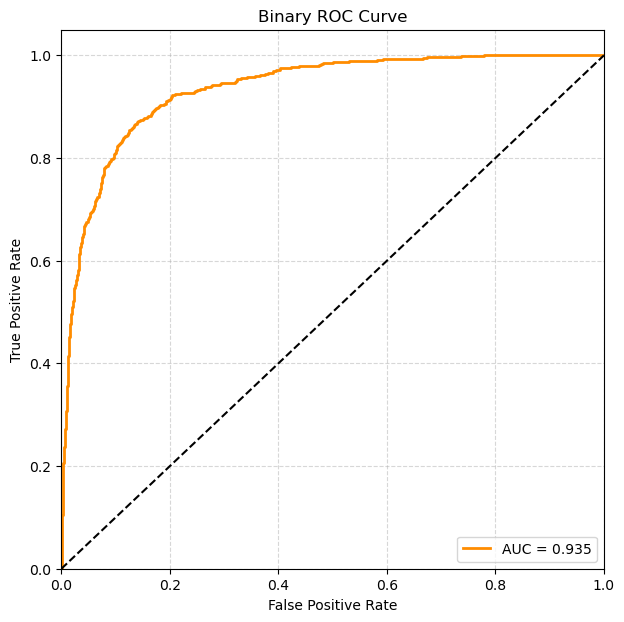


AUC = 0.9345


In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
input_dim = X_test.shape[1]
num_classes = 2

model = HybridNODEAttentionModel(dim=input_dim, num_classes=num_classes)
model.load_state_dict(torch.load(OUT_MODEL, map_location='cpu'))
model = model.to(device)
model.eval()

probs_all = []
y_true = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        out = model(xb)
        probs = F.softmax(out, dim=1).cpu().numpy()
        probs_all.append(probs)
        y_true.extend(yb.numpy())

probs_all = np.vstack(probs_all)
y_true = np.array(y_true)
y_score = probs_all[:, 1]

fpr, tpr, thresholds = roc_curve(y_true, y_score)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7, 7))
plt.plot(fpr, tpr, lw=2, color='darkorange', label=f"AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Binary ROC Curve")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(loc="lower right")
plt.show()

print(f"\nAUC = {roc_auc:.4f}")

### Find threshold using validation data

In [ ]:
# --- Create validation loader ---
val_dataset = TensorDataset(
    torch.from_numpy(X_val.astype(np.float32)),
    torch.from_numpy(y_val.astype(np.int64))
)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# --- Compute danger probabilities (VAL SET) ---
prob_danger_val, true_danger_val = [], []

model.eval()
with torch.no_grad():
    for xb, yb in val_loader:
        xb = xb.to(device)
        out = model(xb)
        probs = F.softmax(out, dim=1)  

        # P(non-AF) = probs[:, 0], so P(AF) = 1 - P(non-AF)
        p_non_af = probs[:, 0]
        p_danger = 1 - p_non_af

        prob_danger_val.extend(p_danger.cpu().numpy())

        # Convert labels → binary danger: SR=0, (Pre-AF + AF)=1
        true_danger_val.extend((yb.numpy() != 0).astype(int))

prob_danger_val = np.array(prob_danger_val)
true_danger_val = np.array(true_danger_val)

print("🔍 Validation danger probability range:",
      prob_danger_val.min(), "-", prob_danger_val.max())
print("Validation danger label distribution:",
      np.bincount(true_danger_val))

# --- Sweep thresholds (VAL SET) ---
candidates = np.arange(0.0, 1.01, 0.01)
f1s, accs, precs, recs = [], [], [], []

for t in candidates:
    preds = (prob_danger_val >= t).astype(int)

    f1s.append(f1_score(true_danger_val, preds))
    accs.append(accuracy_score(true_danger_val, preds))
    precs.append(precision_score(true_danger_val, preds, zero_division=0))
    recs.append(recall_score(true_danger_val, preds))

max_f = max(f1s)
cut = 0.96 * max_f 

valid_idxs = [i for i, f in enumerate(f1s) if f >= cut]

# choose the largest threshold among valid candidates
best_idx = max(valid_idxs)
best_t = candidates[best_idx]

print(f"\n🎯 BEST THRESHOLD (96% F1 rule) = {best_t:.3f}")
print(f"Max F1 = {max_f:.4f}")
print(f"Chosen threshold F1 = {f1s[best_idx]:.4f}, Acc = {accs[best_idx]:.4f}, "
      f"Prec = {precs[best_idx]:.4f}, Rec = {recs[best_idx]:.4f}")

# Final threshold used in inference
window_threshold = best_t


🔍 Validation danger probability range: 5.1259995e-05 - 0.9851544
Validation danger label distribution: [1529  768]

🎯 BEST THRESHOLD (96% F1 rule) = 0.720
Max F1 = 0.8233
Chosen threshold F1 = 0.7918, Acc = 0.8711, Prec = 0.8609, Rec = 0.7331


In [27]:
# --- Show all thresholds with F1 and Accuracy ---
print("\n========== Threshold Summary ==========")
print(f"{'Threshold':<10} {'F1':<10} {'Accuracy':<10}")
print("-" * 35)

for i, t in enumerate(candidates):
    print(f"{t:<10.2f} {f1s[i]:<10.4f} {accs[i]:<10.4f}")




========== Threshold Summary ==========
Threshold  F1         Accuracy  
-----------------------------------
0.00       0.5011     0.3343    
0.01       0.5724     0.5011    
0.02       0.5902     0.5364    
0.03       0.6056     0.5668    
0.04       0.6319     0.6130    
0.05       0.6490     0.6417    
0.06       0.6643     0.6687    
0.07       0.6858     0.7005    
0.08       0.6978     0.7179    
0.09       0.7101     0.7349    
0.10       0.7219     0.7501    
0.11       0.7350     0.7680    
0.12       0.7468     0.7819    
0.13       0.7571     0.7941    
0.14       0.7643     0.8032    
0.15       0.7721     0.8124    
0.16       0.7768     0.8189    
0.17       0.7824     0.8254    
0.18       0.7871     0.8306    
0.19       0.7887     0.8333    
0.20       0.7929     0.8376    
0.21       0.7931     0.8389    
0.22       0.7975     0.8437    
0.23       0.7986     0.8459    
0.24       0.8011     0.8489    
0.25       0.8030     0.8511    
0.26       0.8042     0.8529    

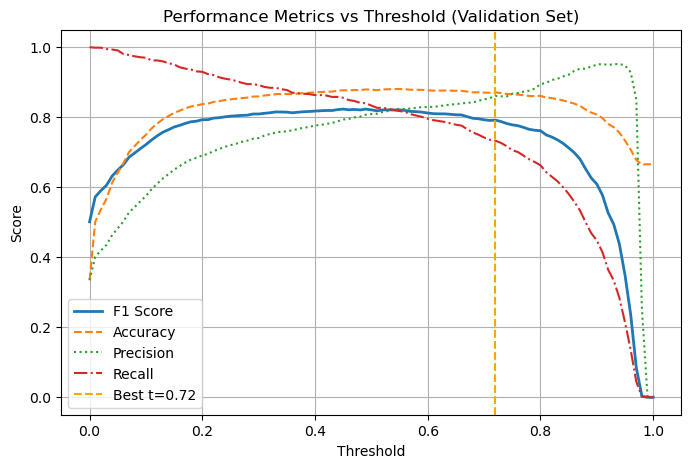

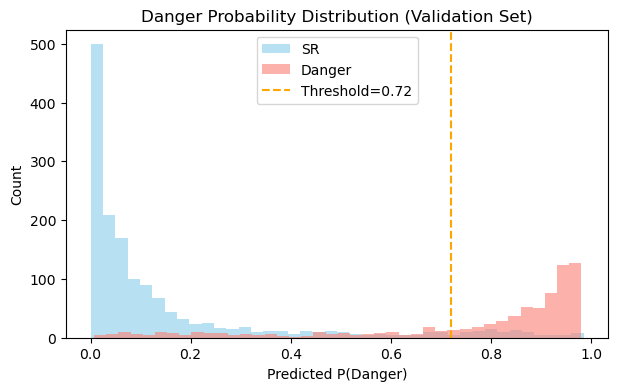

In [28]:

plt.figure(figsize=(8,5))
plt.plot(candidates, f1s, label="F1 Score", linewidth=2)
plt.plot(candidates, accs, label="Accuracy", linestyle="--")
plt.plot(candidates, precs, label="Precision", linestyle=":")
plt.plot(candidates, recs, label="Recall", linestyle="-.")
plt.axvline(best_t, color="orange", linestyle="--", label=f"Best t={best_t:.2f}")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Performance Metrics vs Threshold (Validation Set)")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(7,4))
plt.hist(prob_danger_val[true_danger_val==0], bins=40, alpha=0.6, label="SR", color="skyblue")
plt.hist(prob_danger_val[true_danger_val==1], bins=40, alpha=0.6, label="Danger", color="salmon")
plt.axvline(best_t, color="orange", linestyle="--", label=f"Threshold={best_t:.2f}")
plt.xlabel("Predicted P(Danger)")
plt.ylabel("Count")
plt.title("Danger Probability Distribution (Validation Set)")
plt.legend()
plt.show()